In [2]:
import os
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.interpolate import interp1d
from scipy.signal import medfilt, medfilt2d

# Libraries for plotting, reading data:
import seaborn as sns 
sns.set_style("ticks") # Set seaborn "ticks" style for better styled plots
from astropy.io import fits
from astropy.utils.data import download_file
# Library for some power-spectral density analysis:
from astropy.timeseries import LombScargle

# Corner (for posterior distribution plotting):
import corner
# Juliet (for transit fitting & model evaluation:)
import juliet
#plt.style.use('dark_background')

In [3]:
# Making plots look nicer

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [4]:
# Read in data and calibration files
data_files = sorted(glob.glob("LBT-HAT-P-19/*.fits"))
calibration_files = sorted(glob.glob("LBT-HAT-P-19/calibration/*.fits"))

In [5]:
# function to categorize the calibration files into lamp, flat, and bias
def categorize_calibration(cal_files):
    lamp_calibration = []
    flat_calibration = []
    bias_calibration = []
    
    for i in cal_files:
        data, header = fits.getdata(i, header=True)
        
        if header["MASKNAME"] == "ID582153":
            lamp_calibration.append(i)

        elif header["MASKNAME"] == "ID583213":
            flat_calibration.append(i)

        elif header["IMAGETYP"] == "BIAS":  # tested: if header["IMAGETYP"] == "BIAS" then ["MASKNAME"] == "SIEVEMASK"
            bias_calibration.append(i)

    return lamp_calibration, flat_calibration, bias_calibration

In [6]:
# function to categorize the lamp files by instrument
def categorize_lamp(lamp_files):
    lamp_m1b = []
    lamp_m2b = []
    lamp_m1r = []
    lamp_m2r = []
    
    for i in lamp_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            lamp_m1b.append(i)

        elif header["INSTRUME"] == "MODS2B":
            lamp_m2b.append(i)

        elif header["INSTRUME"] == "MODS1R":
            lamp_m1r.append(i)
            
        elif header["INSTRUME"] == "MODS2R":
            lamp_m2r.append(i)

    return lamp_m1b, lamp_m2b, lamp_m1r, lamp_m2r

In [7]:
# function to categorize the bias files by instrument and take the median of the frames
def categorize_bias_median(bias_files):
    bias_m1b = []
    bias_m2b = []
    bias_m1r = []
    bias_m2r = []
    
    for i in bias_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            bias_m1b.append(data)

        elif header["INSTRUME"] == "MODS2B":
            bias_m2b.append(data)

        elif header["INSTRUME"] == "MODS1R":
            bias_m1r.append(data)
            
        elif header["INSTRUME"] == "MODS2R":
            bias_m2r.append(data)

    ave_bias_m1b = np.median(bias_m1b, axis=0)
    ave_bias_m2b = np.median(bias_m2b, axis=0)
    ave_bias_m1r = np.median(bias_m1r, axis=0)
    ave_bias_m2r = np.median(bias_m2r, axis=0)
    
    return ave_bias_m1b, ave_bias_m2b, ave_bias_m1r, ave_bias_m2r

In [8]:
# function to categorize the flat files by instrument, subtract the master bias frame corresponding to the instrument
# and then take the median of the frames
def categorize_flat_median(flat_files, bias_m1b, bias_m2b, bias_m1r, bias_m2r):
    flat_m1b = []
    flat_m2b = []
    flat_m1r = []
    flat_m2r = []
    
    for i in flat_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            flat_m1b.append(data)

        elif header["INSTRUME"] == "MODS2B":
            flat_m2b.append(data)

        elif header["INSTRUME"] == "MODS1R":
            flat_m1r.append(data)
            
        elif header["INSTRUME"] == "MODS2R":
            flat_m2r.append(data)

    m1b_sub = flat_m1b-bias_m1b
    m2b_sub = flat_m2b-bias_m2b
    m1r_sub = flat_m1r-bias_m1r
    m2r_sub = flat_m2r-bias_m2r
       
    ave_flat_m1b = np.median(m1b_sub, axis=0)
    ave_flat_m2b = np.median(m2b_sub, axis=0)
    ave_flat_m1r = np.median(m1r_sub, axis=0)
    ave_flat_m2r = np.median(m2r_sub, axis=0)
    
    return ave_flat_m1b, ave_flat_m2b, ave_flat_m1r, ave_flat_m2r

In [9]:
def calibrate_data(calibration_files): # setting up calibration files
    lamp, flat, bias = categorize_calibration(calibration_files)
    bias_m1b, bias_m2b, bias_m1r, bias_m2r = categorize_bias_median(bias)
    flat_m1b, flat_m2b, flat_m1r, flat_m2r = categorize_flat_median(flat, bias_m1b, bias_m2b, bias_m1r, bias_m2r)
    lamp_m1b, lamp_m2b, lamp_m1r, lamp_m2r = categorize_lamp(lamp)
    
    # will return a dictionary with the instrument attached to: the master bias, the master flat, 
    # and the list of lamps for that instrument (don't know what to do with the lamps yet)
    calibrate_dict = {
        "m1b":[bias_m1b, flat_m1b, lamp_m1b],
        "m2b":[bias_m2b, flat_m2b, lamp_m2b],
        "m1r":[bias_m1r, flat_m1r, lamp_m1r],
        "m2r":[bias_m2r, flat_m2r, lamp_m2r]
    }
    
    return(calibrate_dict)

In [10]:
cal_dict = calibrate_data(calibration_files)

In [11]:
def flat_errors_calc(flat_files, bias_m1b, bias_m2b, bias_m1r, bias_m2r): # finding the errors on the flat frames
    flat_m1b = []
    flat_m2b = []
    flat_m1r = []
    flat_m2r = []
    
    for i in flat_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            flat_m1b.append(data)

        elif header["INSTRUME"] == "MODS2B":
            flat_m2b.append(data)

        elif header["INSTRUME"] == "MODS1R":
            flat_m1r.append(data)
            
        elif header["INSTRUME"] == "MODS2R":
            flat_m2r.append(data)

    m1b_sub = flat_m1b-bias_m1b
    m2b_sub = flat_m2b-bias_m2b
    m1r_sub = flat_m1r-bias_m1r
    m2r_sub = flat_m2r-bias_m2r
    
    m1b_sub_norm = []
    m2b_sub_norm = []
    m1r_sub_norm = []
    m2r_sub_norm = []
    
    for i in range(len(m1b_sub)): # there is the same number of flat files for all the instruments
        m1b_norm = m1b_sub[i]/np.median(m1b_sub[i])
        m1b_sub_norm.append(m1b_norm)
        
        m2b_norm = m2b_sub[i]/np.median(m2b_sub[i])
        m2b_sub_norm.append(m1b_norm)
        
        m1r_norm = m1r_sub[i]/np.median(m1r_sub[i])
        m1r_sub_norm.append(m1b_norm)
        
        m2r_norm = m2r_sub[i]/np.median(m2r_sub[i])
        m2r_sub_norm.append(m1b_norm)
        
        
    m1b_flat_norm_med = np.median(m1b_sub_norm, axis=0) # finding the normalized median
    m2b_flat_norm_med = np.median(m2b_sub_norm, axis=0)
    m1r_flat_norm_med = np.median(m1r_sub_norm, axis=0)
    m2r_flat_norm_med = np.median(m2r_sub_norm, axis=0)
    
    m1b_flat_error = np.sqrt(np.var(m1b_sub_norm, axis=0)) # finding the stdev per pixel: sqrt(var)
    m2b_flat_error = np.sqrt(np.var(m2b_sub_norm, axis=0))
    m1r_flat_error = np.sqrt(np.var(m1r_sub_norm, axis=0))
    m2r_flat_error = np.sqrt(np.var(m2r_sub_norm, axis=0))
    
    norm_median = [m1b_flat_norm_med, m2b_flat_norm_med, m1r_flat_norm_med, m2r_flat_norm_med]
    errors = [m1b_flat_error, m2b_flat_error, m1r_flat_error, m2r_flat_error]
    
    
    return(norm_median, errors)

In [12]:
def calibrate_data_errors(calibration_files): # finding the error on the flat field data
    lamp, flat, bias = categorize_calibration(calibration_files)
    bias_m1b, bias_m2b, bias_m1r, bias_m2r = categorize_bias_median(bias)
    flat_m1b, flat_m2b, flat_m1r, flat_m2r = categorize_flat_median(flat, bias_m1b, bias_m2b, bias_m1r, bias_m2r)
    norm_med, errors = flat_errors_calc(flat, bias_m1b, bias_m2b, bias_m1r, bias_m2r)
    
    return(norm_med, errors) # returns normalized, bias subtracted median flat frames and associated errors
    

In [13]:
norm_med, flat_error = calibrate_data_errors(calibration_files)

In [14]:
# categorizing just the flat files and bias subtracting them for use
def categorize_flat_bias_subtract(flat_files, bias_m1b, bias_m2b, bias_m1r, bias_m2r):
    flat_m1b = []
    flat_m2b = []
    flat_m1r = []
    flat_m2r = []
    
    for i in flat_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            flat_m1b.append(data)

        elif header["INSTRUME"] == "MODS2B":
            flat_m2b.append(data)

        elif header["INSTRUME"] == "MODS1R":
            flat_m1r.append(data)
            
        elif header["INSTRUME"] == "MODS2R":
            flat_m2r.append(data)

    m1b_sub = flat_m1b-bias_m1b
    m2b_sub = flat_m2b-bias_m2b
    m1r_sub = flat_m1r-bias_m1r
    m2r_sub = flat_m2r-bias_m2r
    
    return m1b_sub,m2b_sub,m1r_sub,m2r_sub

In [15]:
def calibrate_data_flats(calibration_files): # returns calibrated flats for use 
    lamp, flat, bias = categorize_calibration(calibration_files)
    bias_m1b, bias_m2b, bias_m1r, bias_m2r = categorize_bias_median(bias)
    flats_m1b, flats_m2b, flats_m1r, flats_m2r = categorize_flat_bias_subtract(flat, bias_m1b, bias_m2b, bias_m1r, bias_m2r)
    
    return(flats_m1b, flats_m2b, flats_m1r, flats_m2r)

In [17]:
flats_m1b, flats_m2b, flats_m1r, flats_m2r = calibrate_data_flats( calibration_files)

In [18]:
# transpose so wavelength is the rows rather than columns
m1b_mflat_bw = np.transpose(cal_dict["m1b"][1]/np.median(cal_dict["m1b"][1])) 
m2b_mflat_bw = np.transpose(cal_dict["m2b"][1]/np.median(cal_dict["m2b"][1])) 
m1r_mflat_bw = np.transpose(cal_dict["m1r"][1]/np.median(cal_dict["m1r"][1])) 
m2r_mflat_bw = np.transpose(cal_dict["m2r"][1]/np.median(cal_dict["m2r"][1]))

cut_one_m1b = []
for i in m1b_mflat_bw:
    cut_one_m1b.append(i[510:710])
    
cut_two_m1b = []
for i in m1b_mflat_bw:
    cut_two_m1b.append(i[900:1100])

In [19]:
test_medfilt = medfilt(m1b_mflat_bw[0], 3)

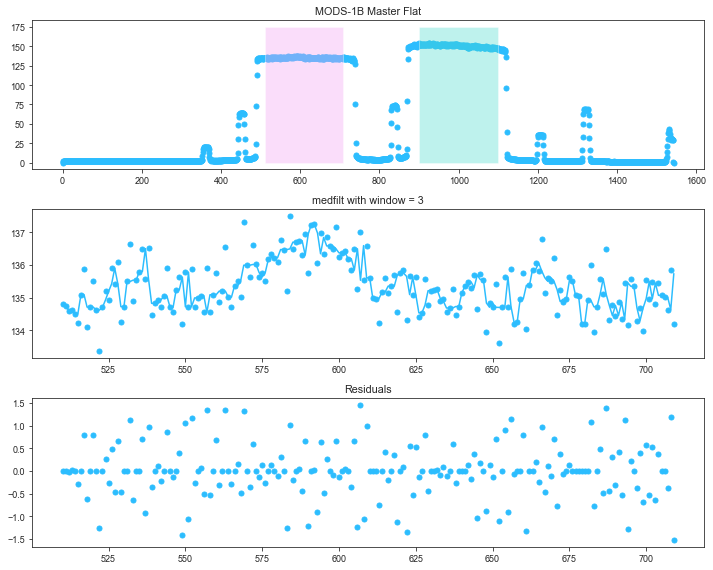

In [20]:
# test using medfilt and the corresponding residuals
# also determine the mods1b peak positions of [510:710], [900:1100]
xs = range(0,len(m1b_mflat_bw[0]),1)

fig, axs = plt.subplots(3, figsize = (10,8))

axs[0].scatter(xs, m1b_mflat_bw[0])
axs[0].fill_between(xs[510:710],175, alpha = 0.35)
axs[0].fill_between(xs[900:1100],175, alpha = 0.35)
axs[0].set_title("MODS-1B Master Flat")

axs[1].scatter(xs[510:710], m1b_mflat_bw[0][510:710])
axs[1].plot(xs[510:710],test_medfilt[510:710])
axs[1].set_title("medfilt with window = 3")

axs[2].scatter(xs[510:710],m1b_mflat_bw[0][510:710]-test_medfilt[510:710])
axs[2].set_title("Residuals")

plt.tight_layout()
plt.show()

In [21]:
# using the best medfilt2d window size of 5, find the points for which the residual value is 
# greater than 5 sigma and mark them
def residual_outliers(spectra_cut): 
    medfilt2d_result = medfilt2d(spectra_cut, 5)
    
    residuals = medfilt2d_result-spectra_cut
    stdev_residuals = np.sqrt(np.var(residuals))
    
    outlier_locations = np.where(abs(residuals)>stdev_residuals*7)
    
    # option to plot positions of the outliers 
    #plt.figure(figsize=(15,10))
    #plt.imshow(spectra_cut)
    #plt.scatter(outlier_locations[1],outlier_locations[0], color = "red")
    #plt.show()
    
    return(outlier_locations)

In [22]:
outlier_locations_m1b_top = residual_outliers(cut_one_m1b)
outlier_locations_m1b_bottom = residual_outliers(cut_two_m1b)

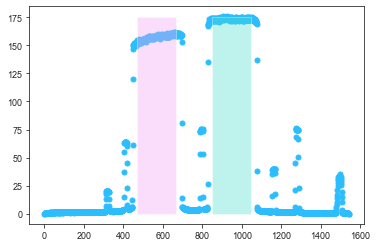

In [23]:
# determine the mods2b peak positions of [470:670], [850:1050]
plt.scatter(xs, m2b_mflat_bw[0])
plt.fill_between(xs[470:670],175, alpha = 0.35)
plt.fill_between(xs[850:1050],175, alpha = 0.35)
plt.show()

In [24]:
cut_one_m2b = []
for i in m2b_mflat_bw:
    cut_one_m2b.append(i[470:670])
    
cut_two_m2b = []
for i in m2b_mflat_bw:
    cut_two_m2b.append(i[850:1050])

In [25]:
outlier_locations_m2b_top = residual_outliers(cut_one_m2b)
outlier_locations_m2b_bottom = residual_outliers(cut_two_m2b)

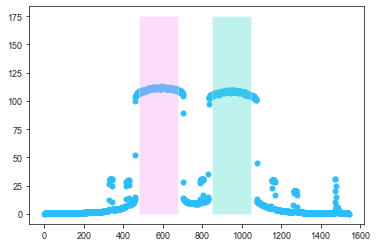

In [26]:
# determine the mods1r peak positions of [480:680], [850:1050]
plt.scatter(xs, m1r_mflat_bw[0])
plt.fill_between(xs[480:680],175, alpha = 0.35)
plt.fill_between(xs[850:1050],175, alpha = 0.35)
plt.show()

In [27]:
cut_one_m1r = []
for i in m1r_mflat_bw:
    cut_one_m1r.append(i[480:680])
    
cut_two_m1r = []
for i in m1r_mflat_bw:
    cut_two_m1r.append(i[850:1050])

In [28]:
outlier_locations_m1r_top = residual_outliers(cut_one_m1r)
outlier_locations_m1r_bottom = residual_outliers(cut_two_m1r)

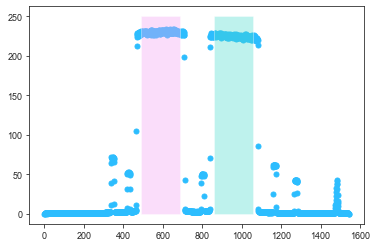

In [29]:
# determine the mods2r peak positions of [490:690], [860:1060]
plt.scatter(xs, m2r_mflat_bw[0])
plt.fill_between(xs[490:690],250, alpha = 0.35)
plt.fill_between(xs[860:1060],250, alpha = 0.35)
plt.show()

In [30]:
cut_one_m2r = []
for i in m2r_mflat_bw:
    cut_one_m2r.append(i[490:690])
    
cut_two_m2r = []
for i in m2r_mflat_bw:
    cut_two_m2r.append(i[860:1060])

In [31]:
outlier_locations_m2r_top = residual_outliers(cut_one_m2r)
outlier_locations_m2r_bottom = residual_outliers(cut_two_m2r)

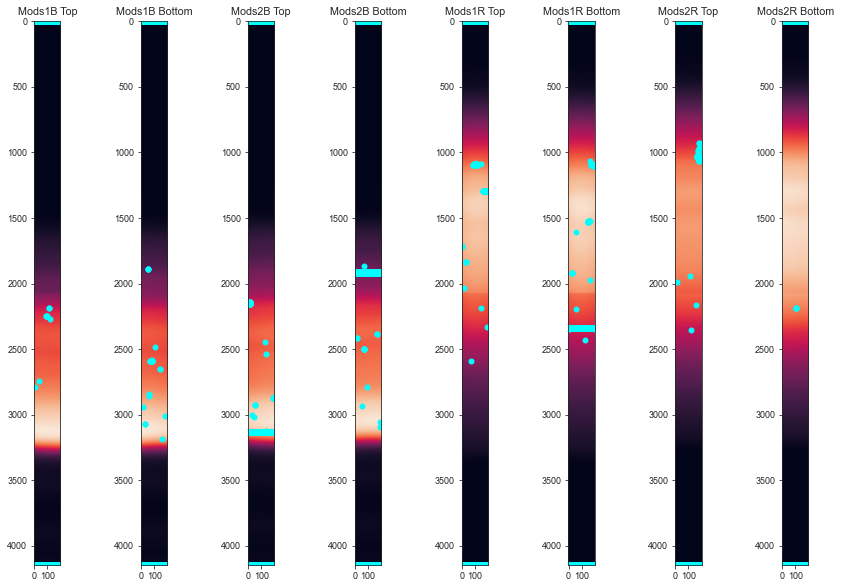

In [32]:
# showing the location of 5 sigma outliers in the flats - likely corresponding to bad pixels
fig, axs = plt.subplots(1, 8,figsize=(15,10))

axs[0].imshow(cut_one_m1b)
axs[0].scatter(outlier_locations_m1b_top[1],outlier_locations_m1b_top[0], color = "cyan")
axs[0].set_title("Mods1B Top")

axs[1].imshow(cut_two_m1b)
axs[1].scatter(outlier_locations_m1b_bottom[1],outlier_locations_m1b_bottom[0], color = "cyan")
axs[1].set_title("Mods1B Bottom")

axs[2].imshow(cut_one_m2b)
axs[2].scatter(outlier_locations_m2b_top[1],outlier_locations_m2b_top[0], color = "cyan")
axs[2].set_title("Mods2B Top")

axs[3].imshow(cut_two_m2b)
axs[3].scatter(outlier_locations_m2b_bottom[1],outlier_locations_m2b_bottom[0], color = "cyan")
axs[3].set_title("Mods2B Bottom")

axs[4].imshow(cut_one_m1r)
axs[4].scatter(outlier_locations_m1r_top[1],outlier_locations_m1r_top[0], color = "cyan")
axs[4].set_title("Mods1R Top")

axs[5].imshow(cut_two_m1r)
axs[5].scatter(outlier_locations_m1r_bottom[1],outlier_locations_m1r_bottom[0], color = "cyan")
axs[5].set_title("Mods1R Bottom")

axs[6].imshow(cut_one_m2r)
axs[6].scatter(outlier_locations_m2r_top[1],outlier_locations_m2r_top[0], color = "cyan")
axs[6].set_title("Mods2R Top")

axs[7].imshow(cut_two_m2r)
axs[7].scatter(outlier_locations_m2r_bottom[1],outlier_locations_m2r_bottom[0], color = "cyan")
axs[7].set_title("Mods2R Bottom")

plt.show()

In [ ]:
# data_clean(cal_dict, data_files) only needs to be run once

In [ ]:
# bias subtracting and then subtracting the median of the edge pixels to normalize the background 
# between the different quadrants resulting in cleaned images
def data_clean(cal_dict, data_files):
    m1b_bias = cal_dict["m1b"][0]
    m2b_bias = cal_dict["m2b"][0]
    m1r_bias = cal_dict["m1r"][0]
    m2r_bias = cal_dict["m2r"][0]
    
    if not os.path.exists("Cleaned_Fits"): 
            os.makedirs("Cleaned_Fits")
    
    for i in data_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B": # break at column 2071
            bias_sub = data-m1b_bias       # left: 0,20, right: [4130:]
            
        elif header["INSTRUME"] == "MODS2B": # break at column 2071
            bias_sub = data-m2b_bias         # left: 3,20, right: [4130:]

            
        elif header["INSTRUME"] == "MODS1R": # break at column 2071
            bias_sub = data-m1r_bias         # left: 2,17, right: [4130:]
        
        elif header["INSTRUME"] == "MODS2R": # break at column 2071 - verified it's the same for all instruments
            bias_sub = data-m2r_bias         # left: 0,18, right: [4130:] - verified it's approx. the same for all
        
        cleaned = []
        for j in bias_sub:
            cleaned_left = j[:2072] - np.median(j[0:20])
            cleaned_right = j[2072:] - np.median(j[4130:])
            cleaned.append(np.concatenate((cleaned_left, cleaned_right), axis=None))
        
        filename = header["FILENAME"] + "_clean.fits"
        
        os.chdir("Cleaned_Fits") # writes out cleaned images to this directory
        fits.writeto(filename, cleaned, header = header, overwrite=True)
        os.chdir("../")

In [33]:
cleaned_data = sorted(glob.glob("Cleaned_Fits/*.fits"))

In [34]:
# test data for trace
data, header = fits.getdata(cleaned_data[0], header=True)

In [35]:
# function to do a basic trace fit to the data
def trace_spectrum_gaussian(data, xi, xf, y_guess, profile_radius = 120, gauss_filter_width = 10):
    # x-axis
    x = np.arange(xi,xf)
    # y-axis
    y = np.arange(data.shape[0])
    
    # Define array that will save centroids at each x:
    y_vals = np.zeros(len(x))
    
    for i in range(len(x)):
        # Convolve column with a gaussian filter; remove median before convolving
        filtered_column = gaussian_filter1d(data[:,x[i]] - np.median(data[:,x[i]]), gauss_filter_width)
        # Find centroid within profile_radius pixels of the initial guess:
        idx = np.where(np.abs(y-y_guess)<profile_radius)[0]
        y_vals[i] = np.sum(y[idx]*filtered_column[idx])/np.sum(filtered_column[idx])
        ystart = y_vals[i]
    return x,y_vals

In [42]:
# function to do a basic trace fit to the data
def trace_spectrum(data, xi, xf, y_guess, profile_radius = 120, gauss_filter_width = 10):
    # x-axis
    x = np.arange(xi,xf)
    # y-axis
    y = np.arange(data.shape[0])
    
    # Define array that will save centroids at each x:
    y_vals = np.zeros(len(x))
    
    for i in range(len(x)):
        # Find centroid within profile_radius pixels of the initial guess:
        idx = np.where(np.abs(y-y_guess)<profile_radius)[0]
        y_vals[i] = np.sum(y[idx]*data[:,x[i]][idx])/np.sum(data[:,x[i]][idx])
        ystart = y_vals[i]
    return x,y_vals

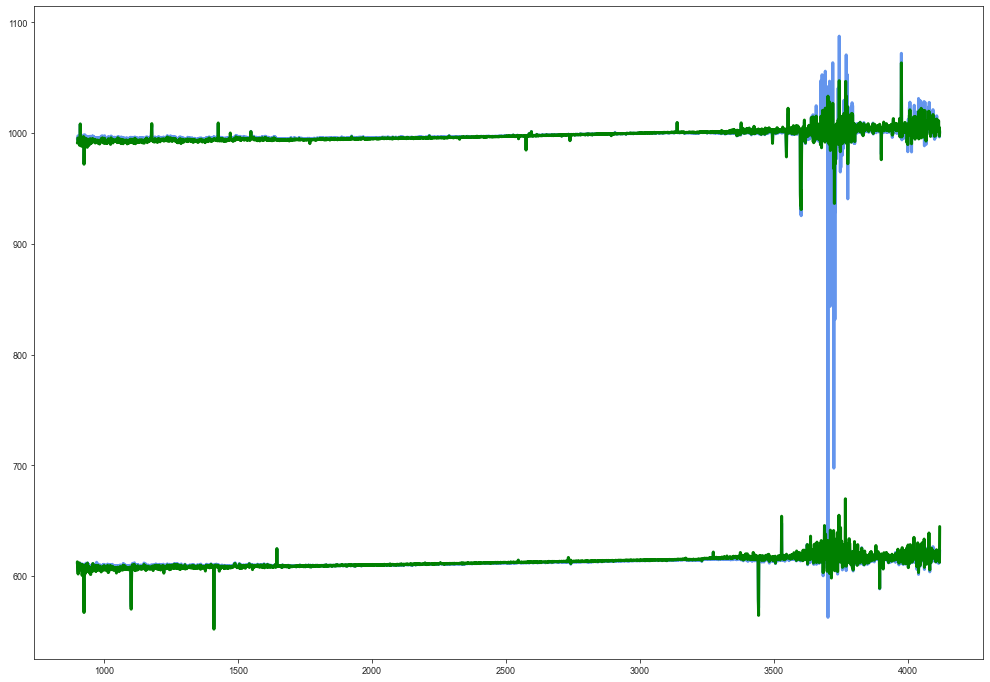

In [65]:
# setting values for trace_spectrum - cut out reference pixels in x 
xi = 900
xf = 4120
y_guess_lower = 1000
y_guess_upper = 610

# plotting the raw data first
plt.figure(figsize=(17,12))
im = plt.imshow(data)
im.set_clim(-5,20)

# find traces for both upper and lower flux, and plot on top of raw data
x_upper, y_upper = trace_spectrum(data, xi, xf, y_guess_upper)
x_lower, y_lower = trace_spectrum(data, xi, xf, y_guess_lower)

x_upper_g, y_upper_g = trace_spectrum_gaussian(data, xi, xf, y_guess_upper)
x_lower_g, y_lower_g = trace_spectrum_gaussian(data, xi, xf, y_guess_lower)


# plots the traces
plt.xlim(0,4144)
plt.ylim(0,1544)
plt.plot(x_upper,y_upper,color='cornflowerblue',lw=3)
plt.plot(x_lower,y_lower,color='cornflowerblue',lw=3)
plt.plot(x_upper_g,y_upper_g,color='green',lw=3)
plt.plot(x_lower_g,y_lower_g,color='green',lw=3)
plt.show()

In [483]:
# mods1b peak positions [510:710], [900:1100]
# mods2b peak positions [470:670], [850:1050]
# mods1r peak positions [480:680], [850:1050]
# mods2r peak positions [490:690], [860:1060]

In [85]:
# function to take cuts of the spectra to feed to the trace function, depending on which instrument the data is from
def trace_spectrum_cuts(file, xi = 900, xf = 4120):
    data, header = fits.getdata(file, header=True)
    
    if header["INSTRUME"] == "MODS1B":
        lower_peak = data[510:710,:]
        upper_peak = data[900:1100,:]
        
        x_lower_cut, y_lower_cut = trace_spectrum(lower_peak, xi, xf, 100)
        x_upper_cut, y_upper_cut = trace_spectrum(upper_peak, xi, xf, 100)
        y_lower_cut_adjust = y_lower_cut + 510
        y_upper_cut_adjust = y_upper_cut + 900
        
    elif header["INSTRUME"] == "MODS2B":
        lower_peak = data[470:670,:]
        upper_peak = data[850:1050,:]
        
        x_lower_cut, y_lower_cut = trace_spectrum(lower_peak, xi, xf, 100)
        x_upper_cut, y_upper_cut = trace_spectrum(upper_peak, xi, xf, 100)
        
        y_lower_cut_adjust = y_lower_cut + 470
        y_upper_cut_adjust = y_upper_cut + 850
        
    elif header["INSTRUME"] == "MODS1R":
        lower_peak = data[480:680,:]
        upper_peak = data[850:1050,:]
        
        x_lower_cut, y_lower_cut = trace_spectrum(lower_peak, xi, xf, 100)
        x_upper_cut, y_upper_cut = trace_spectrum(upper_peak, xi, xf, 100)
        
        y_lower_cut_adjust = y_lower_cut + 480
        y_upper_cut_adjust = y_upper_cut + 850        
        
    elif header["INSTRUME"] == "MODS2R":
        lower_peak = data[490:690,:]
        upper_peak = data[860:1060,:]
        
        x_lower_cut, y_lower_cut = trace_spectrum(lower_peak, xi, xf, 100)
        x_upper_cut, y_upper_cut = trace_spectrum(upper_peak, xi, xf, 100)
        
        y_lower_cut_adjust = y_lower_cut + 490
        y_upper_cut_adjust = y_upper_cut + 860
    
    return [[x_lower_cut, y_lower_cut_adjust], [x_upper_cut, y_upper_cut_adjust]]

In [86]:
# single test frame
test_trace = trace_spectrum_cuts(cleaned_data[0])

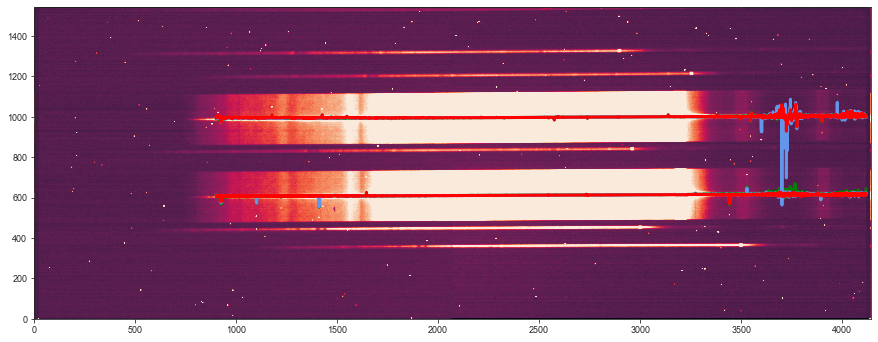

In [87]:
plt.figure(figsize=(15,10))
im = plt.imshow(data)
im.set_clim(-5,20)
plt.xlim(0,4144)
plt.ylim(0,1544)
plt.plot(x_upper_g,y_upper_g,color='green',lw=3)
plt.plot(x_lower_g,y_lower_g,color='green',lw=3)
plt.plot(x_upper,y_upper,color='cornflowerblue',lw=3)
plt.plot(x_lower,y_lower,color='cornflowerblue',lw=3)
plt.plot(test_trace[0][0],test_trace[0][1],color='red',lw=3)
plt.plot(test_trace[1][0],test_trace[1][1],color='red',lw=3)
plt.show()

In [88]:
# using the best medfilt window size of 5, find the points for which the residual value is 
# greater than 5 sigma and mark them - 1d instead of 2d
def residual_outliers_1d(spectra_cut): 
    medfilt_result = medfilt(spectra_cut, 5)
    
    residuals = medfilt_result-spectra_cut
    stdev_residuals = np.sqrt(np.var(residuals))
    
    outlier_locations = np.where(abs(residuals)>stdev_residuals*5)
    
    # option to plot positions of the outliers 
    #plt.figure(figsize=(15,10))
    #plt.imshow(spectra_cut)
    #plt.scatter(outlier_locations[1],outlier_locations[0], color = "red")
    #plt.show()
    
    return(outlier_locations)

In [89]:
test = residual_outliers_1d(y_upper)

In [90]:
test_nan = []
for i in range(len(y_upper)):
    if i in test[0]:
        test_nan.append(np.nan)
    else:
        test_nan.append(y_upper[i])

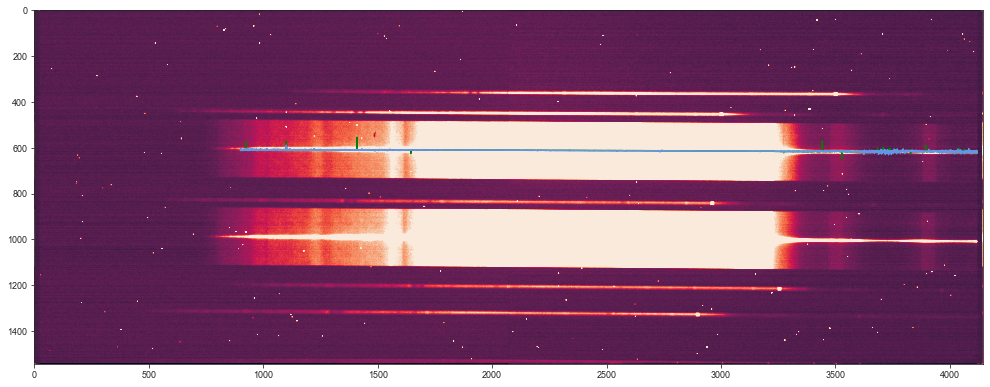

In [91]:
plt.figure(figsize=(17,12))
im = plt.imshow(data)
im.set_clim(-5,20)
plt.plot(x_upper, y_upper, color = "green")
plt.plot(x_upper, test_nan, color = "cornflowerblue")
plt.show()

In [92]:
def select_cheby_order(x,y,min_order,max_order):
    """
    This function selects (and returns) the optimal order of a Chebyshev polynomial using the BIC.
    
    Parameters
    ----------
    x: ndarray
        Array with the regressors
    y: ndarray
        Array with the data
    min_order: int
        Minimum order to try
    max_order: int
        Maximum order to try
    """
    orders = np.arange(min_order,max_order)
    bics = np.zeros(len(orders))
    
    # Fit only non-nans:
    idx = np.where(~np.isnan(y))[0]
    #print(np.array(y)[np.logical_not(np.isnan(y))])
    n = len(idx)
    for i in range(len(orders)):
        order = orders[i]
        coeffs = chebyshev.chebfit(x[np.logical_not(np.isnan(y))] ,np.array(y)[np.logical_not(np.isnan(y))] ,deg=order)
        RSS = np.sum((np.array(y)[np.logical_not(np.isnan(y))] - chebyshev.chebval(x[np.logical_not(np.isnan(y))],coeffs))**2)
        bics[i] = n*np.log(RSS/n) + (order+1)*np.log(n)
    idx = np.where(np.min(bics) == bics)[0]
    return orders[idx][0]


In [93]:
# Try orders from 1 to 30 in the polynomial for all the traces:
orders = select_cheby_order(x_upper,test_nan,1,30)
# Select best order:
order = int(np.median(orders))
print('Best order was: ',order)


Best order was:  8


[]

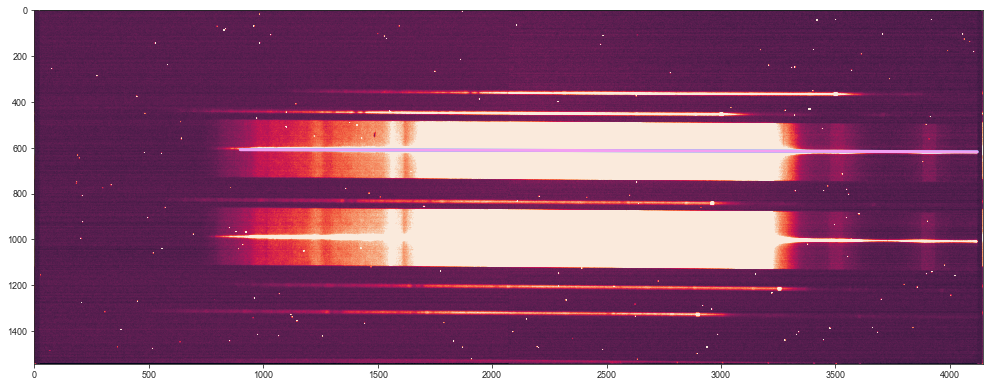

In [94]:
# Use the best-one as deemed by the BIC to fit all the traces; plot them with median image on top:
plt.figure(figsize=(17,12))
im = plt.imshow(data)
im.set_clim(-5,20)

# Fit only non-nans:
coeffs1 = chebyshev.chebfit(np.array(x_upper)[np.logical_not(np.isnan(test_nan))],np.array(test_nan)[np.logical_not(np.isnan(test_nan))],deg=1)
plt.plot(x_upper,chebyshev.chebval(x_upper,coeffs1),lw=3)
coeffs2 = chebyshev.chebfit(np.array(x_upper)[np.logical_not(np.isnan(test_nan))],np.array(test_nan)[np.logical_not(np.isnan(test_nan))],deg=2)
plt.plot(x_upper,chebyshev.chebval(x_upper,coeffs2),lw=3)
plt.plot()

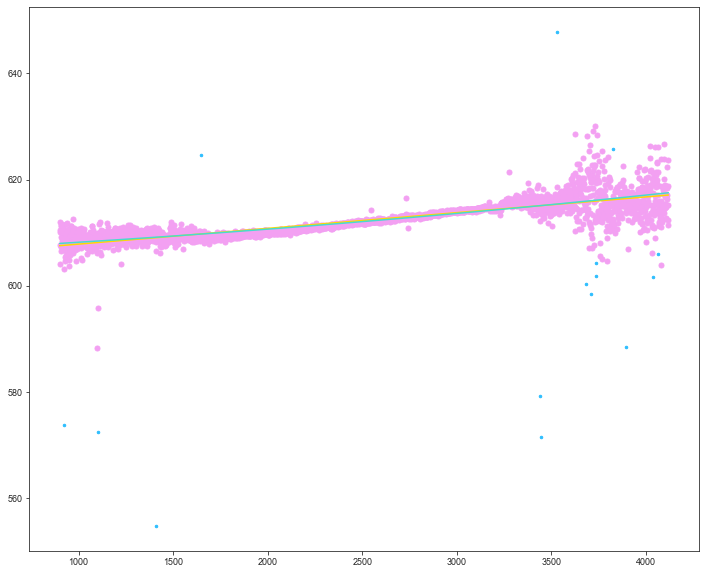

In [95]:
plt.figure(figsize = (12,10))
plt.plot(x_upper, y_upper, '.')
plt.plot(x_upper, test_nan, 'o')
plt.plot(x_upper,chebyshev.chebval(x_upper,coeffs1), color = "gold")
plt.plot(x_upper,chebyshev.chebval(x_upper,coeffs2))
plt.show()

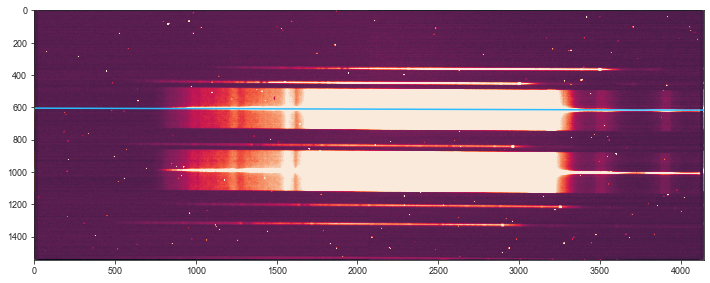

In [96]:
xs = range(0,len(data[0]),1)

plt.figure(figsize=(12,10))
im = plt.imshow(data)
plt.plot(xs,chebyshev.chebval(xs,coeffs1))
im.set_clim(-5,20)
plt.show()